In [ ]:
!pip install numpy
!pip install matplotlib
!pip install somoclu
!pip install rasterio
!pip install scikit-image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


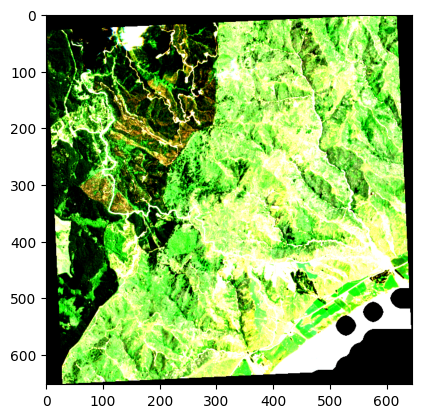

In [1]:
import rasterio
from rasterio.plot import show

# Open the image
with rasterio.open('Data/data/SENTINEL2A.tif') as src:
    # Read the image data
    img = src.read([3,2,1])
    # Display the image
    show(img)
    profile = src.profile


In [2]:
import numpy as np

# Reshape the image into a 2D array
img = img.transpose(1, 2, 0)
h, w, bands = img.shape
data = np.reshape(img, (h*w, bands))

# Normalize the data
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)



In [ ]:
import numpy as np
dt = np.float32(data)

In [3]:
from minisom import MiniSom

# Train the SOM
n_rows, n_cols = 20, 20
som = MiniSom(n_rows, n_cols, bands, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data, 100)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


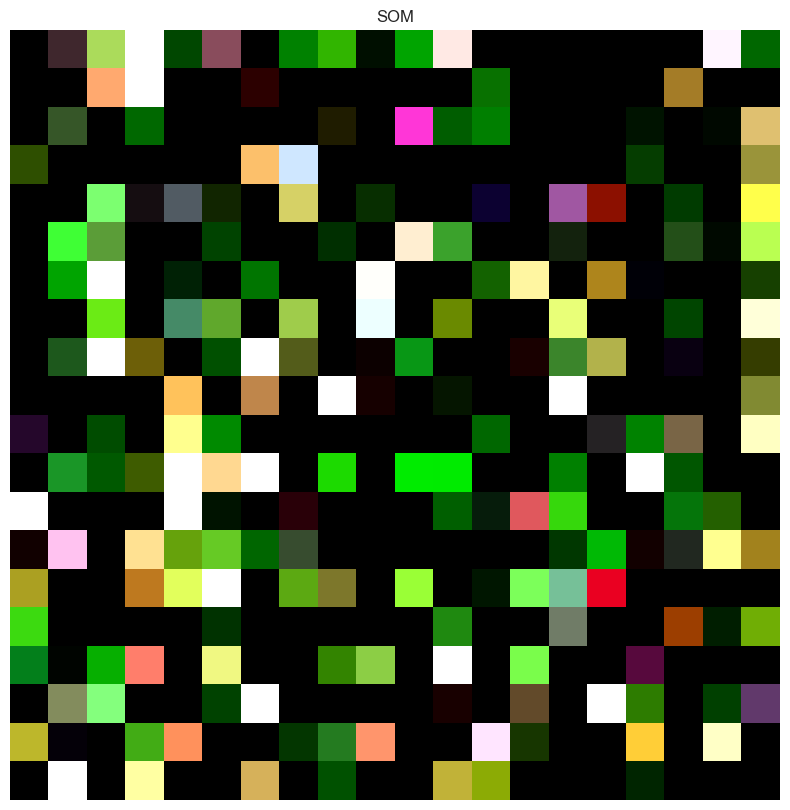

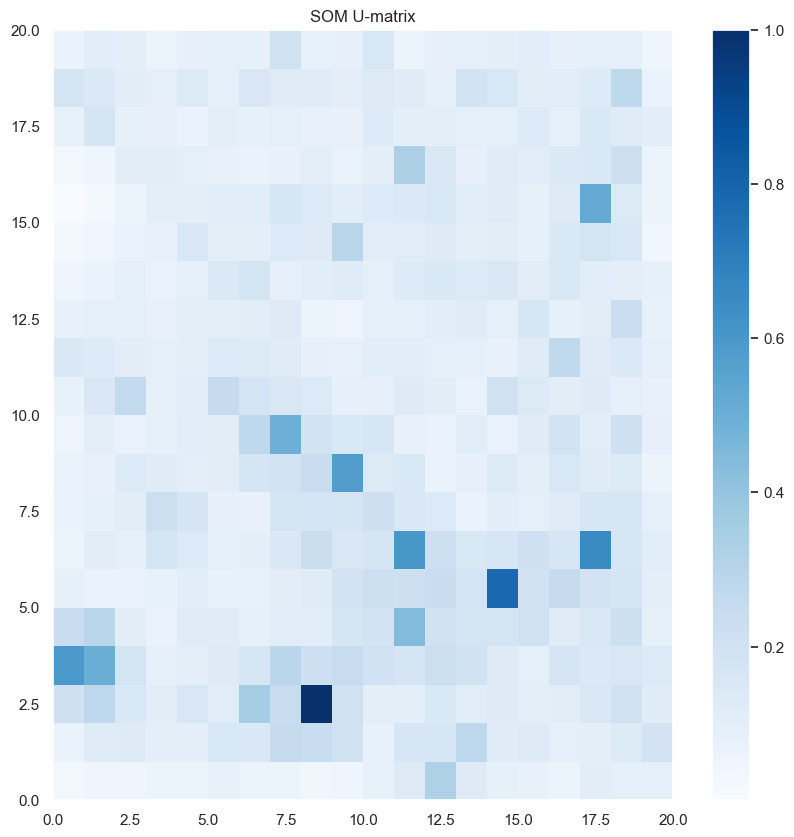

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the SOM
sns.set()
plt.figure(figsize=(10, 10))
plt.imshow(som.get_weights().reshape(n_rows, n_cols, bands))
plt.axis('off')
plt.title('SOM')
plt.show()

# Visualize the data on the SOM
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='Blues')
plt.colorbar()
plt.title('SOM U-matrix')
plt.show()


In [5]:

from skimage import color

# Get the SOM codes for the data
codes = som.get_weights()

# Reshape the codes array to have the same number of dimensions as the data array
codes = np.reshape(codes, (n_rows*n_cols, bands))

# Compute the Euclidean distances between the data and the SOM codes
distances = np.linalg.norm(data[:, np.newaxis, :] - codes, axis=2)

# Assign each pixel to the nearest SOM code
labels = np.argmin(distances, axis=1)

# Reshape the labels into an image
labels_img = labels.reshape(h, w)

# Convert the labels to RGB colors
colors = color.label2rgb(labels_img, colors=sns.color_palette('hls', n_rows*n_cols))
# show(colors)

In [6]:
# Save the segmented image
profile.update(count=3, dtype=rasterio.float32)
with rasterio.open('segmented_som1.tif', 'w', **profile) as dst:
    dst.write(colors.transpose(2, 0, 1))
